# A comparative analysis of accommodation behavior in core QAnon tenets/rhetoric to anti-vaccine rhetoric

In [1]:
import pandas as pd
from shared.mod.sim_matrix import *
dfU = pd.read_csv("/Volumes/V'GER/comp_ling/DataScideProjects/TrackingQ/data/large_scale/layer8/qcvecs.csv")
# Possible values ['vaccine', 'wuhan', 'chinavirus', 'covid']
# dfU = dfU.loc[dfU['w'].isin(['vaccine'])].copy()
dfU['date'] = pd.to_datetime(dfU[['year', 'month', 'day',
                                  'hour', 'minute'
                                  ]])
dfU = dfU.sort_values(by=['date'])
dfU = dfU.drop_duplicates(subset=['uid', 'text'])
dfU.index=range(len(dfU))
dfU['engagements'] = dfU['favorites'].astype(int)+dfU['retweets'].astype(int)

dfU['spans'] = dfU['uname']+'-'+dfU['month'].astype(str)+'/'+dfU['day'].astype(str)+'/'+dfU['year'].astype(str)

dfU = dfU.loc[dfU['year'].isin([2020])].copy()
dfU.index=range(len(dfU))


E = torch.FloatTensor([[np.float(i) for i in vec.replace('[', '').replace(']', '').split(', ')] for vec in dfU['vec'].values])

### Probability Matrix

In [2]:
Pi = probFn(.05)

#Anti-Vax
vm = ~dfU['w'].isin(['pedophile', 'adrenochrome'])
ev = E[vm]
pv = Pi.streamPROB(ev, ev) / Pi.p(torch.FloatTensor([0]))
pv = pv * (torch.eye(pv.shape[0]) == 0).float()

#Adrenochrome
am = dfU['w'].isin(['pedophile', 'adrenochrome'])
ea = E[am]
pa = Pi.streamPROB(ea, ea) / Pi.p(torch.FloatTensor([0]))
pa = pa * (torch.eye(pa.shape[0]) == 0).float()

#Pedophile
# cm = dfU['w'].isin(['pedophile'])
# ec = E[cm]
# pc = Pi.streamPROB(ec, ec) / Pi.p(torch.FloatTensor([0]))
# pc = pc * (torch.eye(pc.shape[0]) == 0).float()

print(pv.shape, pa.shape)

torch.Size([6302, 6302]) torch.Size([5786, 5786])


### Accommodation (using rectangular accommodation)
First, convert all sentences/tweets $x \in X$ to word vectors, extracting the vector for a token $w'$ we're interested in studying.

$$ E_{x,w'} = BERT(x)[\![w']\!] $$

The probability of a word vector, conditioned on the location of a second word vector in vector space is expressed using a half-Gaussian, centered on zero with scale $\sigma$ to set the penalty on cosine error values.

$$ P(E_{x,w'}|E_{y,w'}) = P_{\mathcal{N}_{[0,\infty]}} \left( CoE(E_{x,w'},E_{y,w'}) \bigg| \mu=0, \sigma \right) $$

By comparing the word vector extracted from each utterance to every other word vector we generate a similarity matrix $\mathbb{M}$ as described in my previous paper.

$$ \mathbb{M}^{X,Y} = \bigg\lbrace (x;y): P(E_{x,w'}|E_{y,w'}) \bigg\rbrace $$

And with similarity matrix in hand, we can calculate an accommodation matrix $\mathbb{A}$ which expresses the strength of evidence that each example/tweet $y$ accommodates to a prior example $x$ given a set of prior examples $Z$, with $x$ inclusive.

$$ \mathbb{A}^{X,Y} = \Bigg\lbrace (x,y): N_\mathcal{Z} \left( \frac{ \mathbb{M}^{X,Y}(x,y)}{\sum_\mathcal{Z} \mathbb{M}^{X,Y}(\mathcal{Z},y)} \right) \Bigg\rbrace $$

In [3]:
def accommodation(M):

    I0 = torch.eye(M.shape[0])
    for i in I0.nonzero():
        I0[i[0], i[1]:] = 1

    xout = (torch.eye(M.shape[0]) == 0).float()

    # return ((M * I0 * xout) / (M * I0).sum(dim=0).unsqueeze(0)).nan_to_num() * I0.sum(dim=0).unsqueeze(0)
    return ((M * I0 * xout) / (M * I0 * xout).sum(dim=0).unsqueeze(0)).nan_to_num() * I0.sum(dim=0).unsqueeze(0)


def rectangular_accommodation(M, cond):

    I0 = torch.eye(M.shape[0])
    for i in I0.nonzero():
        I0[i[0], i[1]:] = 1

    xout = (torch.eye(M.shape[0]) == 0).float()

    return ((M * I0 * xout)[cond] / (M * I0 * xout)[cond].sum(dim=0).unsqueeze(0)).nan_to_num() * I0.sum(dim=0).unsqueeze(0)

Av = rectangular_accommodation(pv, dfU['engagements'].loc[vm].values > 25)
Aa = rectangular_accommodation(pa, dfU['engagements'].loc[am].values > 25)
# Ap = rectangular_accommodation(pc, dfU['favorites'].loc[cm].values > 1)

print(Av.shape, Aa.shape)

torch.Size([1919, 6302]) torch.Size([1904, 5786])


Permutation test to make sure that there is indeed a "signal" in the time series

In [4]:
n_samples = 100
av_permutations = [np.random.choice(pv.shape[0], size=(pv.shape[0],), replace=False) for _ in range(n_samples)]

Av_ = []
for i in range(n_samples):
    av_ = rectangular_accommodation(pv[av_permutations[i]][:,av_permutations[i]],
                                    dfU['engagements'].loc[vm].values[av_permutations[i]] > 25)

    Av_ += [(av_>1).float().sum()]

Av_ = torch.FloatTensor(Av_)

print('AntiVax: P(true < permutation) = {} | {} {}'.format((Av_ > (Av > 1).float().sum()).float().mean(), (Av > 1).float().sum(), Av_.mean()))



AntiVax: P(true < permutation) = 0.0 | 623546.0 512977.84375


### Bootstrapping procedure for cross-term comparison

In [5]:
N = 1000
xn = 400
yn = 5000
vX, vY = np.array([np.random.choice(Av.shape[0], size=(xn,), replace=False) for _ in range(N)]), np.array([np.random.choice(Av.shape[-1], size=(yn,), replace=False) for _ in range(N)])
aX, aY = np.array([np.random.choice(Aa.shape[0], size=(xn,), replace=False) for _ in range(N)]), np.array([np.random.choice(Aa.shape[-1], size=(yn,), replace=False) for _ in range(N)])
# pX, pY = np.array([np.random.choice(Ap.shape[0], size=(200,), replace=False) for _ in range(N)]), np.array([np.random.choice(Ap.shape[-1], size=(1000,), replace=False) for _ in range(N)])

dAv, dAa, dAp = [], [], []
for i in range(N):
    # Summed results
    # dAv += [(Av[vX[i]][:,vY[i]] > 1).sum().float().view(-1)]
    # dAa += [(Aa[aX[i]][:,aY[i]] > 1).sum().float().view(-1)]

    # Mean results
    dAv += [(Av[vX[i]][:,vY[i]] > 1).float().mean().view(-1)]
    dAa += [(Aa[aX[i]][:,aY[i]] > 1).float().mean().view(-1)]

dAv, dAa = torch.cat(dAv), torch.cat(dAa)

n = torch.distributions.Normal(dAa.mean(), dAa.std())

print('Pedophilia Message Statistics: mu={}, std={}'.format(dAa.mean(), dAa.std()))
print('anti-vaccination message statistics: mu={}, std={}'.format(dAv.mean(), dAv.std()))
print('useful comparisons: pedophilia/anti-vax mu={}, P(anti-vax_score|pedophilia distribution)={}'.format(dAa.mean()/dAv.mean(), torch.exp(n.log_prob(dAv.mean()))))

Pedophilia Message Statistics: mu=0.11319618672132492, std=0.003958064131438732
anti-vaccination message statistics: mu=0.05149479955434799, std=0.0024703466333448887
useful comparisons: pedophilia/anti-vax mu=2.1982061862945557, P(anti-vax_score|pedophilia distribution)=0.0


plotting the distributions of scores

In [6]:
from scipy.stats import ttest_ind as ttest
ttest(dAa.numpy(), dAv.numpy()), (((dAv >= (dAa.mean()-(2*dAa.std())))) > 0).float().mean()


(Ttest_indResult(statistic=418.1930420811533, pvalue=0.0), tensor(0.))

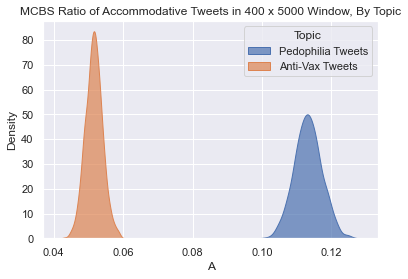

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')

dfa = [[val.item(), 'Pedophilia Tweets'] for val in dAa]+[[val.item(), 'Anti-Vax Tweets'] for val in dAv]
dfa = pd.DataFrame(np.array(dfa), columns=['A', 'Topic'])
dfa.A = dfa.A.astype(float)

sns.kdeplot(data=dfa, x='A', hue='Topic', alpha=.7, fill=True)
plt.title('MCBS Ratio of Accommodative Tweets in {} x {} Window, By Topic'.format(xn,yn))
plt.show()

### Burstiness score

First, per each tweet, we calculate the mean time difference between accommodating tweets.

$$ \mu_{\tau_x} = \frac{1}{N} \sum_x \left( \tau_{x,y} - \tau_{x,y-1} \right) \delta_{\mathbb{A} (x;y) \geq 2} $$

As well as the standard deviation.

$$ \sigma_{\tau_x} = \sqrt \frac{\sum_x \left( ( \tau_{x,y} - \tau_{x,y-1} ) - \mu_{\tau_x} \right)^2 \delta_{\mathbb{A} (x;y) \geq 2}}{N} $$

Both terms are then used to calculate Barabasi's Burstiness Quotient ($B$)
$$ B = \frac{(\sigma_{\tau_x}/\mu_{\tau_x}) - 1}{(\sigma_{\tau_x}/\mu_{\tau_x}) + 1} $$

or, we can express the coefficient $B$ as follows after reducing it.

$$ B = \frac{\sigma_{\tau_x} - \mu_{\tau_x}}{\sigma_{\tau_x} + \mu_{\tau_x}} $$


In [8]:
# Example code
import time
#Vaccine Rhetoric
dfT = dfU.loc[vm].copy()
dfT.index=range(len(dfT))
x = (Av > 1).float()
tau_delta = [[time.mktime(j.timetuple()) for j in dfT['date'].loc[[i]+xi.nonzero().view(-1).tolist()]] for i,xi in enumerate(x)]
tau_delta = [(np.array(tauset)[1:]-np.array(tauset)[:-1]) for tauset in tau_delta]

mu = torch.FloatTensor([np.mean(tauset) for tauset in tau_delta]).nan_to_num()
sigma = torch.FloatTensor([np.std(tauset) for tauset in tau_delta]).nan_to_num()

vB = ((sigma - mu) / (sigma+mu)).nan_to_num()

#Pedophilia Rhetoric
dfT = dfU.loc[am].copy()
dfT.index=range(len(dfT))
x = (Aa > 1).float()
tau_delta = [[time.mktime(j.timetuple()) for j in dfT['date'].loc[[i]+xi.nonzero().view(-1).tolist()]] for i,xi in enumerate(x)]
tau_delta = [(np.array(tauset)[1:]-np.array(tauset)[:-1]) for tauset in tau_delta]

mu = torch.FloatTensor([np.mean(tauset) for tauset in tau_delta]).nan_to_num()
sigma = torch.FloatTensor([np.std(tauset) for tauset in tau_delta]).nan_to_num()

aB = ((sigma - mu) / (sigma+mu)).nan_to_num()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


T-Test procedure comparing busrstiness scores of anti-vaccine rhetoric to discussions of QAnon members' beliefs in widespread pedophilia.

In [9]:
N = 1000
samples = 400

vX = np.array([np.random.choice(vB.shape[0], size=(samples,), replace=False) for _ in range(N)])
aX = np.array([np.random.choice(aB.shape[0], size=(samples,), replace=False) for _ in range(N)])

dAv, dAa = [], []
for i in range(N):
    dAv += [vB[vX[i]].mean().view(-1)]
    dAa += [aB[aX[i]].mean().view(-1)]
    # dAp += [(Ap[pX[i]][:,pY[i]] > 1).sum().float().view(-1)]
dAv, dAa = torch.cat(dAv), torch.cat(dAa)

Some basic statistics concerning burstiness of both anti-vaccine tweets and those discussing pedohpilia beliefs.

In [10]:
print('Pedophilia Message Statistics: mu={}, std={}'.format(dAa.mean(), dAa.std()))
print('anti-vaccination message statistics: mu={}, std={}'.format(dAv.mean(), dAv.std()))
print('useful comparisons: pedophilia/anti-vax mu={}'.format(dAa.mean()/dAv.mean()))

Pedophilia Message Statistics: mu=0.8375797271728516, std=0.0065170833840966225
anti-vaccination message statistics: mu=0.7284336090087891, std=0.007951989769935608
useful comparisons: pedophilia/anti-vax mu=1.149836778640747


Graphing burstiness scores . . .

In [11]:
from scipy.stats import ttest_ind as ttest
ttest(dAa.numpy(), dAv.numpy()), (((dAv >= (dAa.mean()-(2*dAa.std())))) > 0).float().mean()


(Ttest_indResult(statistic=335.70487161018235, pvalue=0.0), tensor(0.))

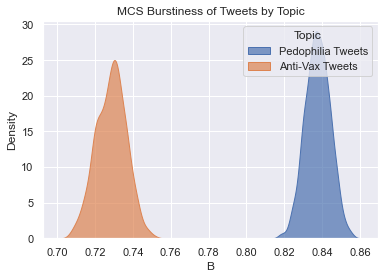

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')

dfa = [[val.item(), 'Pedophilia Tweets'] for val in dAa]+[[val.item(), 'Anti-Vax Tweets'] for val in dAv]
dfa = pd.DataFrame(np.array(dfa), columns=['B', 'Topic'])
dfa.B = dfa.B.astype(float)

sns.kdeplot(data=dfa, x='B', hue='Topic', alpha=.7, fill=True)
plt.title('MCS Burstiness of Tweets by Topic')
plt.show()

### Visualizing the relationship between accommodation and burstiness

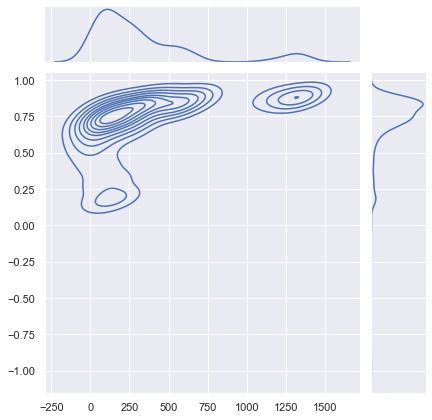

(0.4615848713884471, 7.165040529770175e-102)


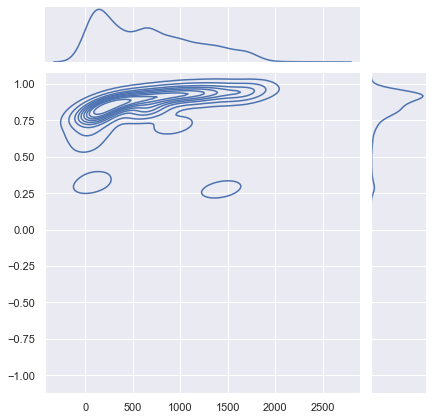

(0.3552260531177043, 9.997430092559453e-58)


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as pr
sns.set_theme(style='darkgrid')

denomv, denoma = torch.FloatTensor((dfU['engagements'].loc[vm].values > 25).nonzero()[0]-1), torch.FloatTensor((dfU['engagements'].loc[am].values > 25).nonzero()[0]-1)

v_,a_ = (Av > 1).sum(dim=-1), (Aa > 1).sum(dim=-1)

g = sns.jointplot(x=v_.numpy(), y=vB, kind='kde')
plt.show()
print(pr(v_.numpy(),vB.numpy()))

f = sns.jointplot(x=a_.numpy(), y=aB, kind='kde')
plt.show()
print(pr(a_.numpy(),aB.numpy()))

And the relationship of engagements to our measures.

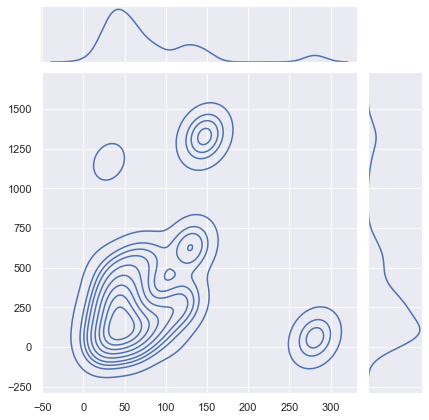

(0.22092544478869744, 1.207978181144603e-22)


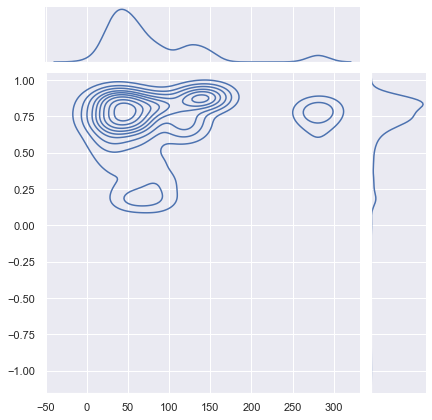

(0.04370588288888025, 0.05558639977160609)


In [14]:
cond_v, cond_a = dfU['engagements'].loc[vm].values > 25, dfU['engagements'].loc[am].values > 25
engagements_v, engagements_a = dfU['retweets'].loc[vm].values[cond_v], dfU['retweets'].loc[am].values[cond_a]

g = sns.jointplot(y=v_.numpy(), x=engagements_v, kind='kde')
plt.show()
print(pr(v_.numpy(),engagements_v))

g = sns.jointplot(y=vB.numpy(), x=engagements_v, kind='kde')
plt.show()
print(pr(vB.numpy(),engagements_v))

### Mutual information between influencers [Note: theory still being revised]
So what explains the burstinesss? One possible explanation is that the group is largely divided and that people glomp on to particular influencers in their network. We can test that by figuring out:

1. The rate that people emulate one of the "influencers" left by our selection criterion and then
2. Comparing the entropy of influencers based on their rates of influence on other members of the population.

Low entropy would mean, in general, low mutual information between influencers and followers, and would indicate divisions in the network--i.e. distinct sub-networks.

$$ P(H_{x,y}|x) = \frac{N_{H_{x,y}}}{N_{H_y}} $$

$$ H[x_i|x_j] = log_2 P(H_{x_i,y}|x_i) - log_2 P(H_{x_j,y}|x_j) $$

In [ ]:
cond = vm
C = (dfU['favorites'].loc[cond].values > 1) | (dfU['retweets'].loc[cond].values > 100)
unames = dfU['uname'].loc[cond].values

Pxi_y = torch.cat([Av[unames[C]==i].sum(dim=0).unsqueeze(0) for i in np.unique(unames[C])], dim=0).T
Pxi_y = torch.cat([Pxi_y[unames==i].sum(dim=0).unsqueeze(0) for i in np.unique(unames)], dim=0).T
Pxi_y = (Pxi_y/Pxi_y.sum(dim=0).unsqueeze(0)).nan_to_num()

def H(x, log=torch.log):
    hx = -log(x)
    return torch.cat([(hx[i]-hx).sum(dim=-1).unsqueeze(0) for i in range(len(hx))], dim=0)
